In [1]:
!pip install torchtext==0.6.0
!pip install spacy
!python -m spacy download en
!python -m spacy download de

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.3/12.8 MB 10.2 MB/s eta 0:00:02
     -- ------------------------------------- 0.9/12.8 MB 9.4 MB/s eta 0:00:02
     ---- ----------------------------------- 1.4/12.8 MB 11.3 MB/s eta 0:00:02
     ------ --------------------------------- 1.9/12.8 MB 11.1 MB/s eta 0:00:01
     ------- -------------------------------- 2.5/12.8 MB 11.4 MB/s eta 0:00:01
     --------- ------------------------------ 3.0/12.8 MB 11.3 MB/s eta 0:00:01
     ---------- ----------------------------- 3.5/12.8 MB 11.1 MB/s eta 0:00:01
     ------------ --------------------------- 3.9/12.8 MB 11.2 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.8 MB 11.5 MB/s eta 0:00:01
     --------------- ------------------------ 4.8/12.8 MB 11.0 MB/s eta 0:00:01
     

In [2]:
import os
import numpy as np
import time
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import SGD
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.utils import get_tokenizer
from torchtext import data
from torchtext.data.metrics import bleu_score
import spacy
from spacy.symbols import ORTH
import math
import random
import tqdm.notebook as tq
import copy

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
# Manually fix Multi30K download link, since the original server is down. (https://github.com/pytorch/text/issues/1756)
Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz",
]

Multi30k는 대표적인 영어-독어 번역 데이터셋이다.

In [34]:
SRC = Field(tokenize = "spacy",
            tokenizer_language="de_core_news_sm",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en_core_web_sm",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG), test='test')

SRC와 TRG는 각각 deutsch와 english로부터 얻어진 field이고, train_dataset, valid_dataset, test_dataset은 이를 split하여 저장한 것이다. 각 dataset의 크기는 다음과 같다.

In [28]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


예를 들어 index 30에 해당하는 독어와 영어 문장 dataset을 출력하면 다음과 같다.

In [35]:
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


이렇게 얻어진 field 객체에서 build_vocab 메서드를 이용해 영어와 독어의 단어 사전을 생성한다. 이때 min_freq=2로 설정하여 최소 2번 이상 등장한 단어만을 선택한다.

In [38]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7853
len(TRG): 5893


vocab.stoi["string"]을 사용하면 해당 field로부터 생성된 사전에서 "string"이 몇 번째 단어인지 확인할 수 있다.

In [40]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # : 2
print(TRG.vocab.stoi["<eos>"]) # : 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


In [41]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

BucketIterator는 DataLoader와 유사하게 사용할 수 있는데, 추가적으로 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들어주는 역할을 한다.

예를 들어 train_iterator의 첫 번째 배치의 첫 문장에 포함된 정보를 출력하면 다음과 같다.

In [69]:
for i, batch in enumerate(train_iterator):
    src = batch.src.T
    trg = batch.trg.T

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 26])
인덱스 0: 2
인덱스 1: 13
인덱스 2: 10
인덱스 3: 45
인덱스 4: 170
인덱스 5: 12
인덱스 6: 6
인덱스 7: 2615
인덱스 8: 8
인덱스 9: 0
인덱스 10: 21
인덱스 11: 4
인덱스 12: 3
인덱스 13: 1
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1


첫 index는 2(\<sos\>), 마지막 index는 3(\<eos\>)이고 나머지 부분은 1(padding)으로 채워진 것을 확인할 수 있다.

In [70]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

Multi-Head Attention Layer는 linear transformation을 통해 query, key, value를 받아서 $Q, K, V$로 바꾼다. 그 다음으로 energy인 $\frac{QK^\intercal}{\sqrt{d_k}}$를 계산하고, mask가 사용되는 경우 mask==0인 부분을 -1e10으로 채운다. 추후 transformer 모델을 정의할 때 padding 토큰으로 차있는 부분을 0으로 채운 mask를 적용시킨다.

이렇게 구한 energy에 softmax를 취한 $\text{softmax}(\frac{QK^\intercal}{\sqrt{d_k}})$가 attention이 되고, 여기에 $V$를 곱한 $\text{softmax}(\frac{QK^\intercal}{\sqrt{d_k}})V$가 최종 output x가 된다.

In [71]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

Position-wise Feed-forward Layer는 $\text{FFN}(x)=\text{ReLU}(xW_1+b_1)W_2+b2$를 구현한 것이다.

In [72]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

Encoder Layer를 이루는 4가지 구성요소를 나타내는 코드를 다시 적으면 다음과 같다.

```python
_src, _ = self.self_attention(src, src, src, src_mask)
src = self.self_attn_layer_norm(src + self.dropout(_src))
_src = self.positionwise_feedforward(src)
src = self.ff_layer_norm(src + self.dropout(_src))
```

각각 Multi-Head Attention, Add & Norm, Feed Forward, Add & Norm을 나타내는 코드이다.

In [73]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

Encoder에서 positional embedding의 경우 논문에서 언급한 sine/cosine function을 사용하지 않고 직접 학습하는 형태로 구현했다. src를 input으로 받았을 때 tok_embedding을 거쳐 hidden_dim 차원으로 축소시키고 scaling한 다음 positional embedding 벡터를 더했고, n_layers(6)개의 EncoderLayer를 거쳐 output src를 얻었다.

In [74]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

Decoder Layer를 이루는 6가지 구성요소를 나타내는 코드를 다시 적으면 다음과 같다.

```python
_trg, _ = self.self_attention(trg, trg, trg, trg_mask)
trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
_trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
_trg = self.positionwise_feedforward(trg)
trg = self.ff_layer_norm(trg + self.dropout(_trg))
```

각각 Masked Multi-Head Attention, Add & Norm, Multi-Head Attention, Add & Norm, Feed Forward, Add & Norm을 나타내는 코드이다.

In [75]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

Decoder도 encoder에서와 마찬가지로 positional embedding을 직접 학습하는 형태로 구현했다. trg를 input으로 받았을 때 tok_embedding을 거쳐 hidden_dim 차원으로 축소시키고 scaling한 다음 positional embedding 벡터를 더했고, n_layers(6)개의 DecoderLayer를 거쳐 fc_out 층을 통과해 최종 output_dim 차원의 output을 얻었다.

In [76]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의  토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

전체적인 Transformer의 구조는 src를 encoder에 통과시켜 enc_src를 얻은 다음, trg와 enc_src를 이용하여 output을 얻는 것이 된다.

In [77]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [78]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [79]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [80]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [81]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [82]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src.T
        trg = batch.trg.T

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스()는 제외
        # 입력을 할 때는 부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0()은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [83]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src.T
            trg = batch.trg.T

            # 출력 단어의 마지막 인덱스()는 제외
            # 입력을 할 때는 부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0()은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [84]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [85]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 5m 3s
	Train Loss: 4.230 | Train PPL: 68.711
	Validation Loss: 3.031 | Validation PPL: 20.716
Epoch: 02 | Time: 5m 3s
	Train Loss: 2.812 | Train PPL: 16.651
	Validation Loss: 2.292 | Validation PPL: 9.892
Epoch: 03 | Time: 5m 24s
	Train Loss: 2.230 | Train PPL: 9.304
	Validation Loss: 1.975 | Validation PPL: 7.209
Epoch: 04 | Time: 4m 56s
	Train Loss: 1.878 | Train PPL: 6.538
	Validation Loss: 1.796 | Validation PPL: 6.026
Epoch: 05 | Time: 5m 2s
	Train Loss: 1.632 | Train PPL: 5.115
	Validation Loss: 1.693 | Validation PPL: 5.434
Epoch: 06 | Time: 4m 50s
	Train Loss: 1.444 | Train PPL: 4.238
	Validation Loss: 1.652 | Validation PPL: 5.218
Epoch: 07 | Time: 4m 55s
	Train Loss: 1.299 | Train PPL: 3.664
	Validation Loss: 1.611 | Validation PPL: 5.008
Epoch: 08 | Time: 5m 0s
	Train Loss: 1.170 | Train PPL: 3.222
	Validation Loss: 1.622 | Validation PPL: 5.062
Epoch: 09 | Time: 4m 55s
	Train Loss: 1.061 | Train PPL: 2.888
	Validation Loss: 1.608 | Validation PPL: 4.995
Ep

In [86]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.674 | Test PPL: 5.333


In [87]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에  토큰, 마지막에  토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는  토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # 를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [88]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
소스 문장 인덱스: [2, 8, 364, 10, 134, 70, 624, 565, 19, 780, 200, 20, 88, 4, 3]
모델 출력 결과: a mother and her small son enjoying a beautiful day outdoors . <eos>


In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\mathd\AppData\Local\Temp\ipykernel_25928\1757982450.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
C:\Users\mathd\AppData\Local\Temp\ipykernel_25928\1757982450.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


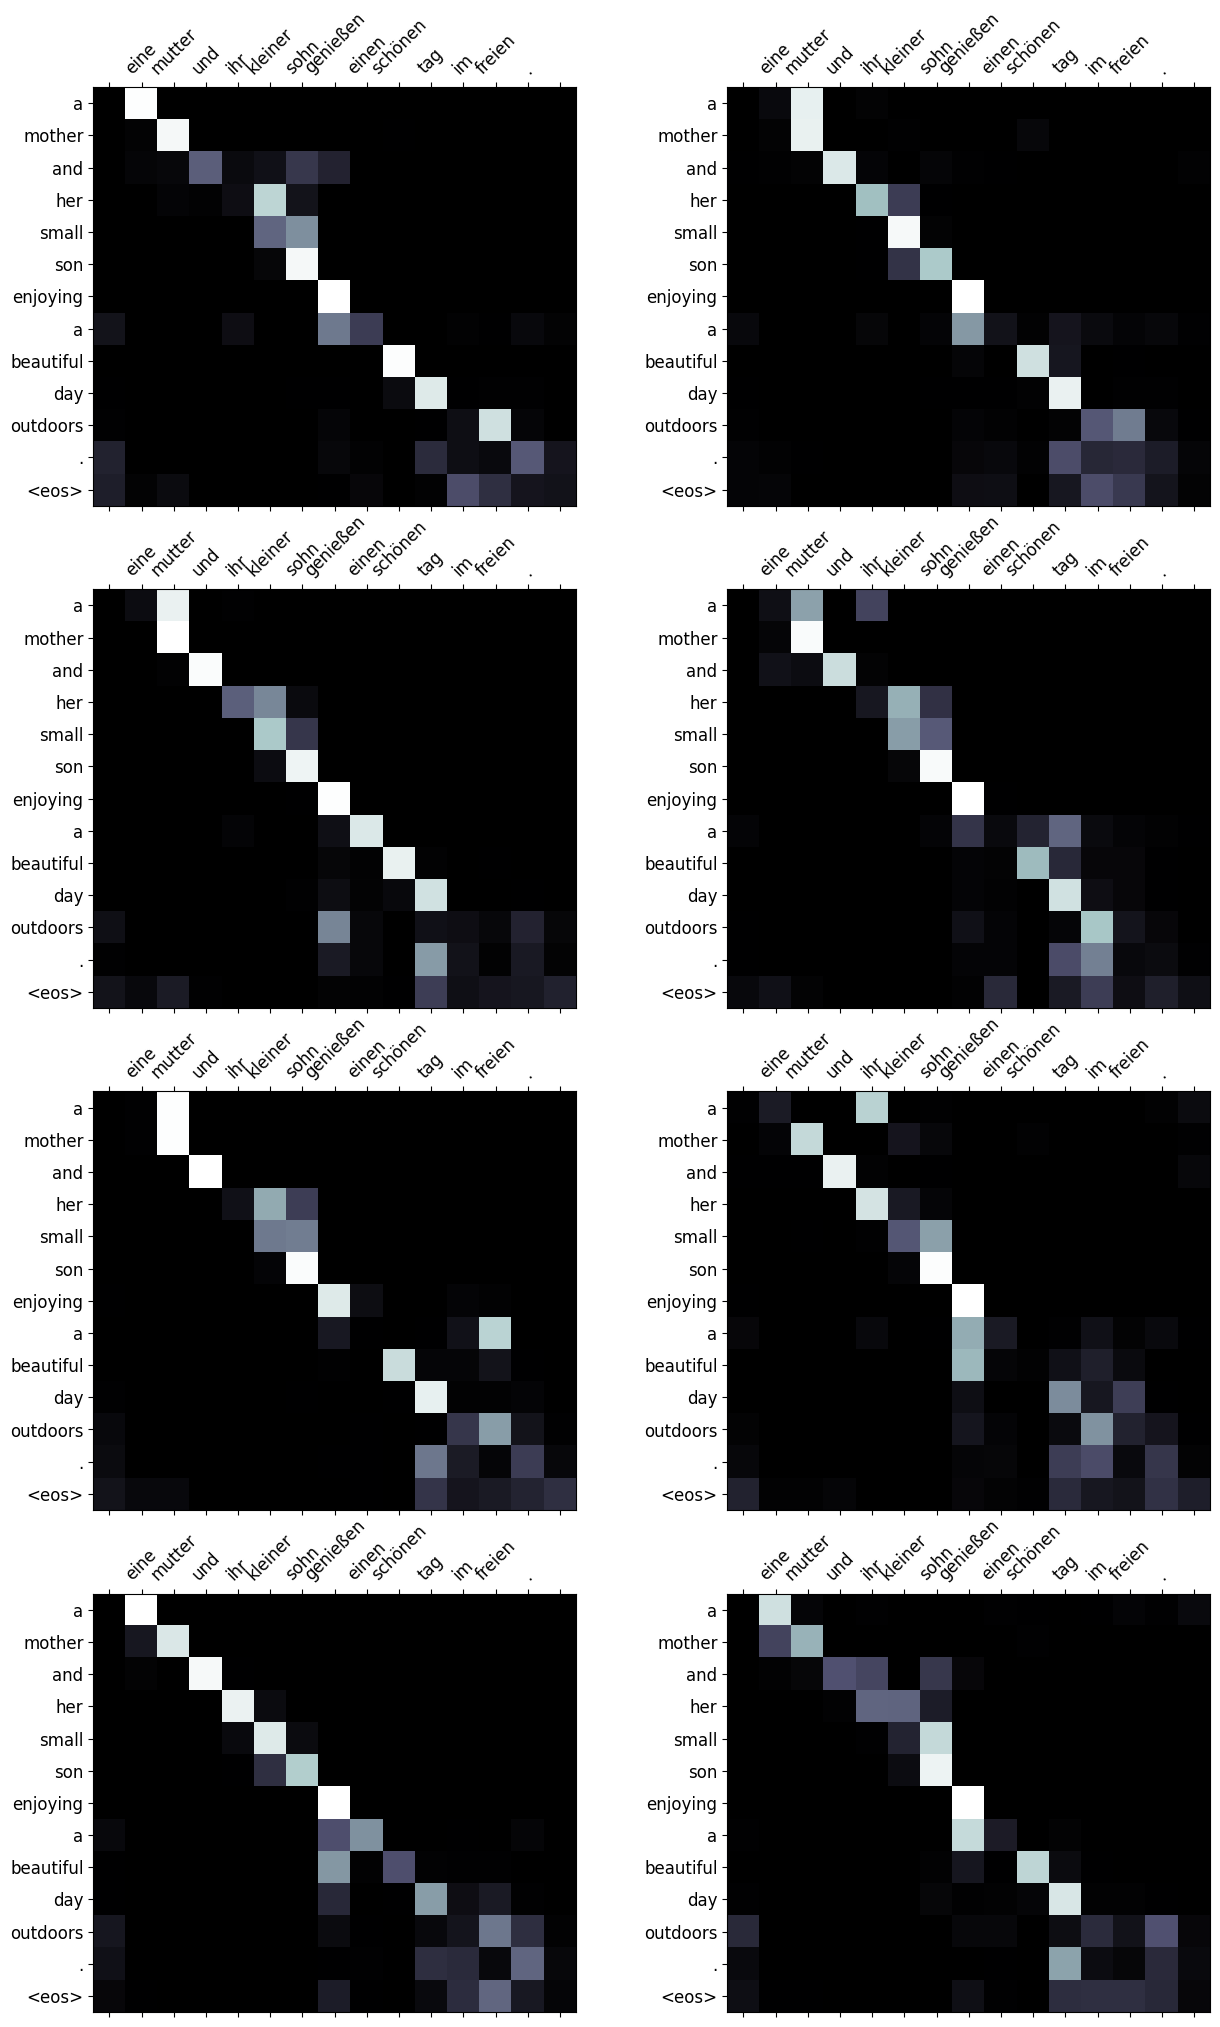

In [90]:
display_attention(src, translation, attention)

In [91]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막  토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [92]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'sit', 'down', 'on', 'blue', 'chairs', 'indoors', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
예측: ['all', 'of', 'people', 'standing', 'under', 'umbrellas', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
예측: ['a', 'goalie', 'in', 'a', 'yellow', 'jersey', 'brushes', 'the', 'goal', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
예측: ['two', 'small', 'children', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
예측: ['two', 'medium', '-', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[600/1000]
예측: ['a', 'group', 'of', 'men', 'sit', 'and', 'talk', 'while', 'conversing', 'with', 'green', 'tape', '.']
정답: ['a', 'g